### BoomBikes Bike Sharing

**Business Case:**

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

A US bike-sharing provider `BoomBikes` has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

The company wants to know:
	- Which variables are significant in predicting the demand for shared bikes.
	- How well those variables describe the bike demands
Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

#### Business Goal:
You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

In [1]:
# suppres warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

### Step - 1. Reading, understandig and visualising data

#### 1.1 Reading and Understanding data

In [3]:
# reading data set
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
# getting insights of dataframe
df.shape

(730, 16)

In [5]:
# getting descriptive insights of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


There is no Null values in the column and majority of data are having numerical values except date column.

In [6]:
# Check for any duplicate entries
df.duplicated().sum()

0

There is no duplicate entries found in the dataset

Insights:
-  `instant` column is a record index which does not have any significance in out analysis. So we will drop the column  
- The varibles `casual` and `registered` are summed up to get `cnt` which is our target variable. Also during prediction we wll not be having these data, so we will drop these two variables which we are not going to use in the model.
- We are going to use `weekday` varible which is derived from `dteday`, so we will not be using `dteday` and will drop it.
- `temp` and `atemp` are directly correlated among each other. We will use `temp` and drop `atemp`.

In [7]:
# drop columns instance, dteday, casual, registered and atemp
df.drop(['instant', 'dteday','casual','registered','atemp'], axis=1, inplace=True)

In [8]:
# After droppping the variables checking the columns abnd rows in the dataframe
df.shape

(730, 11)

In [9]:
# identify categorical variables
cat_vars = ['season','yr','mnth','holiday','weekday', 'workingday','weathersit']

# identify numeric variables
num_vars = ['temp', 'hum','windspeed','cnt']

In [10]:
# convert dtype of categorical variables
df[cat_vars] = df[cat_vars].astype('category')

In [11]:
# get insights of numeric variable
df.describe()

,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000
mean,20.319259,62.765175,12.763620,4508.006849
std,7.506729,14.237589,5.195841,1936.011647
min,2.424346,0.000000,1.500244,22.000000
25%,13.811885,52.000000,9.041650,3169.750000
50%,20.465826,62.625000,12.125325,4548.500000
75%,26.880615,72.989575,15.625589,5966.000000
max,35.328347,97.250000,34.000021,8714.000000


In [12]:
# get the insights of categorical variables
df.describe(include=['category'])

,season,yr,mnth,holiday,weekday,workingday,weathersit
count,730,730,730,730,730,730,730
unique,4,2,12,2,7,2,3
top,3,1,12,0,2,1,1
freq,188,365,62,709,105,504,463


**Data Disctionary:**<br>
Below categorical columns are having following catecteristics and can be maped with respective values:
- `season` column is having four seasons as (1:spring, 2:summer, 3:fall, 4:winter)
- `mnth` column is having 12 categorical values denoting for months Jan to Dec
- `weathersit` is having for categorical values (1: Clear_FewClouds, 2: Mist_Cloudy, 3: LightSnow_LightRain, 4: HeavyRain_IcePallets)
- `weekday` column having 7 varibles ( 0 to 6 ) denoting (0: Sun, 1: Mon 2: Tue, 3: Wed, 4: Thu, 5: Fri, 6: Sat) 

`yr`, `holiday`, `workingday` are having binary values. So we will not map these columns

In [13]:
# maped the season column according to descripttions
df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

# maped the weekday column according to descriptin
df['weekday'] = df['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})


# maped mnth column values (1 to 12 ) as (jan to dec) respectively
df['mnth'] = df['mnth'].map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct',
                             11: 'nov', 12:'dec'})

#  maped weathersit column
df['weathersit'] = df['weathersit'].map({1: 'Clear_FewClouds', 2: 'Mist_Cloudy', 3: 'LightSnow_LightRain', 4: 'HeavyRain_IcePallets'})

### Step - 2. Data  Visualisation

In [14]:
# Check the data info before proceeding for analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    category
 2   mnth        730 non-null    category
 3   holiday     730 non-null    category
 4   weekday     730 non-null    category
 5   workingday  730 non-null    category
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   hum         730 non-null    float64 
 9   windspeed   730 non-null    float64 
 10  cnt         730 non-null    int64   
dtypes: category(7), float64(3), int64(1)
memory usage: 29.3 KB


#### 2.1 Univariate analaysis

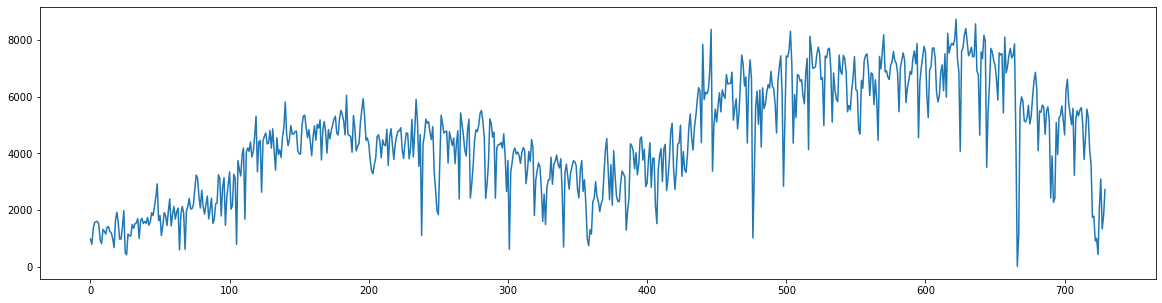

In [15]:
# visualise the pattern of demand (target variable - 'cnt') over period of two years
plt.figure(figsize=(20,5))
plt.plot(df.cnt)
plt.show()

Insights:
- We can observe that there was growth over the period and recently we could see there is reduction in demand

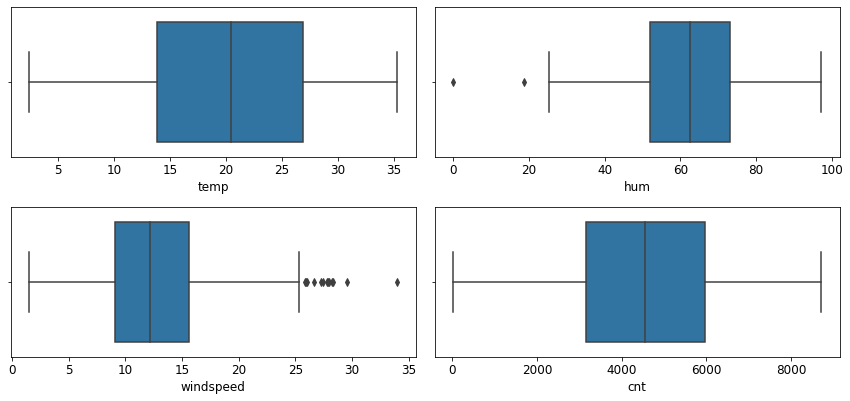

In [16]:
# Visualising numerical varibles

# selecting numerical variables
var = df.select_dtypes(exclude = 'category').columns

# Box plot
col = 2
row = len(var)//col+1

plt.figure(figsize=(12,8))
plt.rc('font', size=12)
for i in list(enumerate(var)):
    plt.subplot(row, col, i[0]+1)
    sns.boxplot(df[i[1]])    
plt.tight_layout()   
plt.show()

Insights:
- From the above plots it could be observed that `hum` and `windspeed` are having few outliers.

In [17]:
# get percentage outlier for hum and windspeed

# function to get outlier percentage
def percentage_outlier(x):
    iqr = df[x].quantile(0.75)-df[x].quantile(0.25)
    HL = df[x].quantile(0.75)+iqr*1.5
    LL = df[x].quantile(0.25)-iqr*1.5
    per_outlier = ((df[x]<LL).sum()+(df[x]>HL).sum())/len(df[x])*100
    per_outlier = round(per_outlier,2)
    return(per_outlier)

print('Percentage of outlier (hum): ', percentage_outlier('hum'))
print('Percentage of outlier (windspeed): ', percentage_outlier('windspeed'))

Percentage of outlier (hum):  0.27
Percentage of outlier (windspeed):  1.78


Insights:
- Percentage of outlier for `hum` and `windspeed` are `0.27` and `1.78` respectively.
- As these percentage is low, and we can see there is no significant abnormal outlier value. So we will leave it as it is.

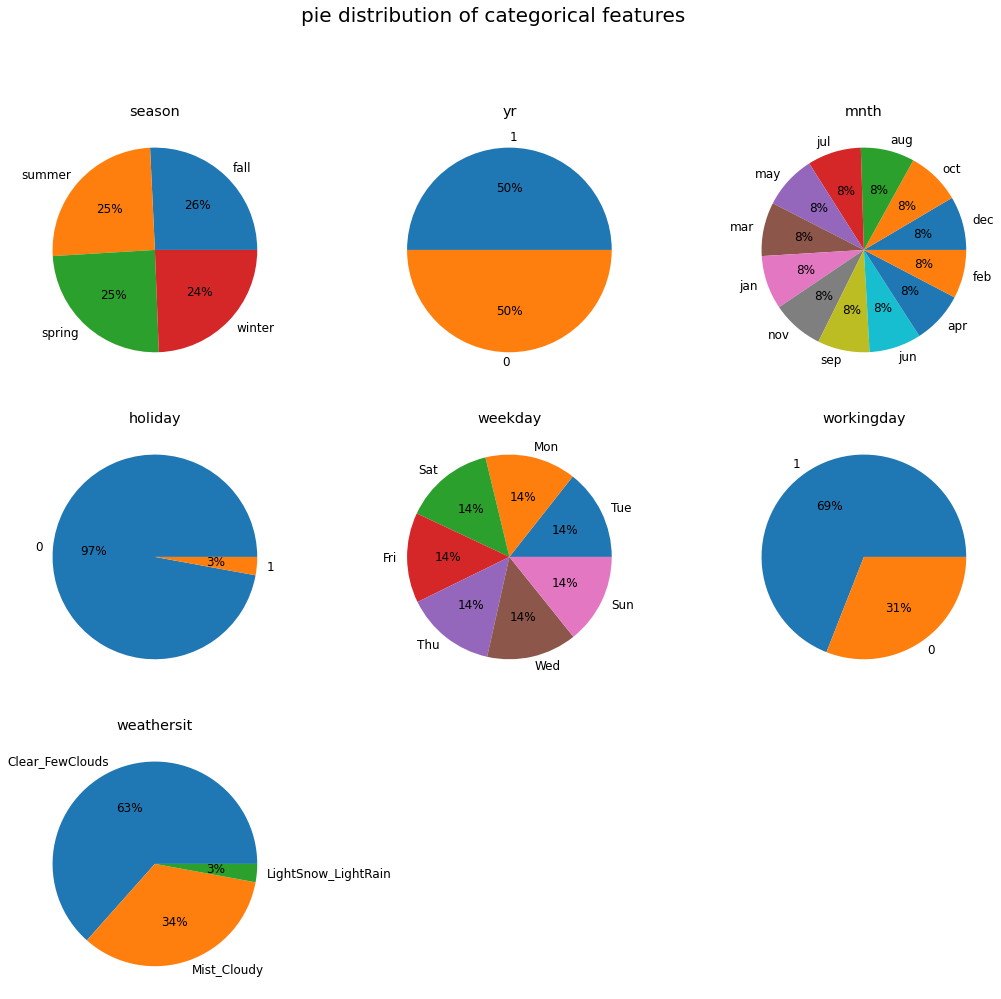

In [18]:
# # # Visulalising Categorical Variables using pie chart

df_piplot=df.select_dtypes(include='category')
plt.figure(figsize=(18,16))
plt.suptitle('pie distribution of categorical features', fontsize=20)
for i in range(1,df_piplot.shape[1]+1):
    plt.subplot(3,3,i)
    f=plt.gca()
    f.set_title(df_piplot.columns.values[i-1])
    values=df_piplot.iloc[:,i-1].value_counts(normalize=True).values
    index=df_piplot.iloc[:,i-1].value_counts(normalize=True).index
    plt.pie(values,labels=index,autopct='%1.0f%%')
# plt.tight_layout(pad = 0.5)
plt.show()

In [19]:
# # Visulalising Categorical Variables
# # selecting categorical variables
# var = df.select_dtypes(include='category').columns

# # Box plot
# col = 3
# row = len(var)//col+1

# plt.figure(figsize=(12,12))
# # plt.rc('font', size=12)
# for i in list(enumerate(var)):
#     plt.subplot(row, col, i[0]+1)
#     sns.countplot(df[i[1]])
#     plt.xticks(rotation = 90)
# plt.tight_layout(pad = 1.0)
# plt.show()

**Insights:**
- Seasons:   We could see business was operating similar days in all four seasons.
- Yr:   Number of days operation in both the year are almost same.
- Month: We could see business was operating similar days in all 12 months.
- Holiday: Business was operating in 3% days of holiday
- weekdays: We could see business was operating similar percentage in all weekdays.
- Workingday: Bisuness was operating in 68% in workign days and 32% in nonworking days.
- Weathersit: From the above analaysis it is being observed that there is no data for 4th category of `weathersit i.e Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog`.May be the company is not operating on those days or there was no demand of bike.

#### 2.2 Bi-Variate analysis

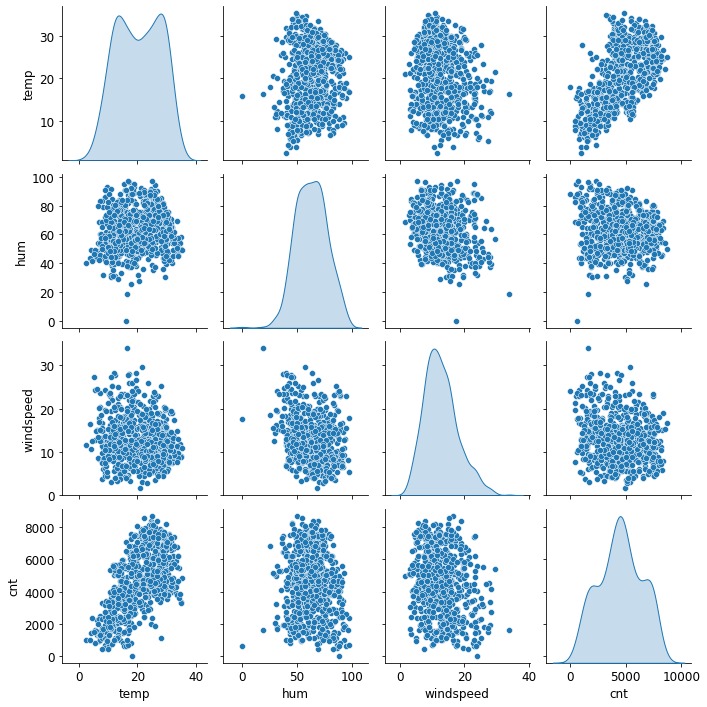

In [20]:
# pairplot for continuous data type
sns.pairplot(df.select_dtypes(['int64','float64']), diag_kind='kde')
plt.show()

**Insights:**<br>
From the above pairplot we could observe that, `temp` has highest positive correlation with target variable `cnt`.

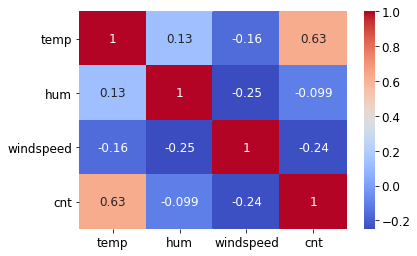

In [21]:
# look at the correaltion between continous varibales using heat map
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

We could infer follwing observation:
> - A positive correalation observed between `cnt` and `temp` (0.63)
> - A Negative correlation observed for `cnt` with `hum` and `windspeed` (-0.099 and -0.24)

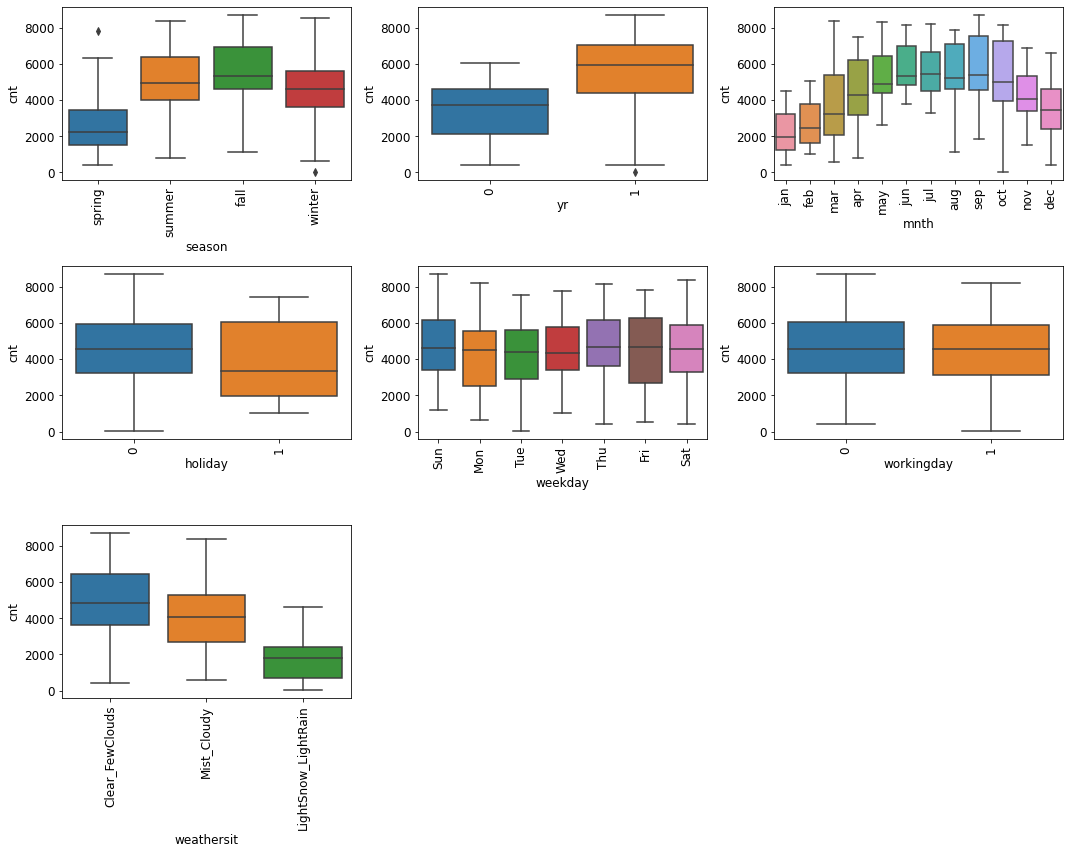

In [22]:
# Box plot for categorical variables
col = 3
row = len(cat_vars)//col+1

plt.figure(figsize=(15,12))
for i in list(enumerate(cat_vars)):
    plt.subplot(row,col,i[0]+1)
    sns.boxplot(x = i[1], y = 'cnt', data = df)
    plt.xticks(rotation = 90)
plt.tight_layout(pad = 1)    
plt.show()

**Insights:**<br>
Q. From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

Answer:
- The demad of bike is less in the month of `spring` when compared with other seasons
- The demand bike increased in the year 2019 when compared with year 2018.
- Month Jun to Sep is the period when bike demand is high. The Month Jan is the lowest demand month.
- Bike demand is less in holidays in comparison to not being holiday.
- The demand of bike is almost similar throughout the weekdays.
- There is no significant change in bike demand with workign day and non working day.
- The bike demand is high when weather is `clear and Few clouds` however demand is less in case of `Lightsnow and light rainfall`. We do not have any dat for `Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog` , so we can not derive any conclusion. May be the company is not operating on those days or there is no demand of bike.

### Step - 3. Data Preparation

### 3.1 Creating of dummy variables

In [23]:
# get dummy variables for season, weekday, mnth and weathersit
dummy_vars = pd.get_dummies(df[['season','weekday','mnth','weathersit']],drop_first=True)

# concat the dummy df with original df
df = pd.concat([df,dummy_vars], axis = 1)

# drop season column
df.drop(['season','weekday','mnth','weathersit'], axis=1, inplace=True)

df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
0,0,0,1,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,14.902598,69.6087,16.652113,801,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# check data frame
df.shape

(730, 29)

In [25]:
# Check datafrmae
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   yr                              730 non-null    category
 1   holiday                         730 non-null    category
 2   workingday                      730 non-null    category
 3   temp                            730 non-null    float64 
 4   hum                             730 non-null    float64 
 5   windspeed                       730 non-null    float64 
 6   cnt                             730 non-null    int64   
 7   season_summer                   730 non-null    uint8   
 8   season_fall                     730 non-null    uint8   
 9   season_winter                   730 non-null    uint8   
 10  weekday_Mon                     730 non-null    uint8   
 11  weekday_Tue                     730 non-null    uint8   
 12  weekday_Wed           

yr, holiday and workign day columns are showing datatype 'categorical' but these data  are 0 and 1. So we will convert these data type to `uint8`

In [26]:
# Convert categorical columns to numeric 
df[['yr','holiday','workingday']]= df[['yr','holiday','workingday']].astype('uint8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   yr                              730 non-null    uint8  
 1   holiday                         730 non-null    uint8  
 2   workingday                      730 non-null    uint8  
 3   temp                            730 non-null    float64
 4   hum                             730 non-null    float64
 5   windspeed                       730 non-null    float64
 6   cnt                             730 non-null    int64  
 7   season_summer                   730 non-null    uint8  
 8   season_fall                     730 non-null    uint8  
 9   season_winter                   730 non-null    uint8  
 10  weekday_Mon                     730 non-null    uint8  
 11  weekday_Tue                     730 non-null    uint8  
 12  weekday_Wed                     730 

### 3.2 Splitting data into test and train set 

In [27]:
# Split train test dataset
df_train, df_test = train_test_split(df, train_size = 0.7, random_state = 10 )
print(df_train.shape)
print(df_test.shape)

(510, 29)
(220, 29)


### 3.3 Scaling of data set

- During EDA we could observe that there is different range of data in the data set. So it becomes important to scale the data. 
- Here we will be using Min-Max scaling (normalisation) to scale both training and tesing dataset.

**Training Data scaling**

In [28]:
# Scaling of train set

# instantiate an object
scaler = MinMaxScaler()

# fit and transform on training data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
72,0,0,1,0.298094,0.393891,0.236118,0.194978,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510,1,0,0,0.778657,0.694105,0.364071,0.737052,1,0,0,...,1,0,0,0,0,0,0,0,0,0
700,1,0,1,0.327249,0.809877,0.210252,0.509236,0,0,1,...,0,0,0,0,0,0,0,1,1,0
264,0,0,0,0.694699,0.910249,0.217975,0.526862,0,1,0,...,0,0,0,0,1,0,0,0,1,0
577,1,0,1,0.811368,0.624004,0.244886,0.863093,0,1,0,...,0,0,0,1,0,0,0,0,0,0


**Testing data scaling**

In [29]:
# check test dataset before scaling
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,24.429153,86.5417,14.291100,4459,0,1,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,12.656536,64.6522,12.565984,3598,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,29.622500,39.6250,6.874736,5362,0,1,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,26.581653,56.9583,17.000111,7363,1,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,28.358347,47.0000,18.542250,4758,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [30]:
# transform test dataset 
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0.486297,0,1,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0.382349,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0.817910,0.265533,0.165370,0.595316,0,1,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,0.836895,1,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0.522395,0,1,0,...,0,0,0,1,0,0,0,0,0,0


### 3.4 Split data set into X and y sets (for both train and test set)

In [31]:
# Creating X and y data dataframe for train set
y_train = df_train.pop('cnt')
X_train = df_train
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
72,0,0,1,0.298094,0.393891,0.236118,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510,1,0,0,0.778657,0.694105,0.364071,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
700,1,0,1,0.327249,0.809877,0.210252,0,0,1,1,...,0,0,0,0,0,0,0,1,1,0
264,0,0,0,0.694699,0.910249,0.217975,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
577,1,0,1,0.811368,0.624004,0.244886,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [32]:
# Creating X and y data dataframe for test set
y_test = df_test.pop('cnt')
X_test = df_test

X_test.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0.817910,0.265533,0.165370,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


### Step - 4. Data Modeling and Evaluation

### 4.1 Recusive feature elemination (RFE)

In [33]:
# Checking variables for for X_train columns
X_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_summer', 'season_fall', 'season_winter', 'weekday_Mon',
       'weekday_Tue', 'weekday_Wed', 'weekday_Thu', 'weekday_Fri',
       'weekday_Sat', 'mnth_feb', 'mnth_mar', 'mnth_apr', 'mnth_may',
       'mnth_jun', 'mnth_jul', 'mnth_aug', 'mnth_sep', 'mnth_oct', 'mnth_nov',
       'mnth_dec', 'weathersit_Mist_Cloudy', 'weathersit_LightSnow_LightRain'],
      dtype='object')

In [34]:
# Running RFE to select 15 number of varibles
# Create object
lm = LinearRegression()
# fit model
lm.fit(X_train, y_train)
# run RFE
rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, y_train)

# Select columns
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_summer',
       'season_fall', 'season_winter', 'mnth_mar', 'mnth_may', 'mnth_aug',
       'mnth_sep', 'mnth_oct', 'weathersit_Mist_Cloudy',
       'weathersit_LightSnow_LightRain'],
      dtype='object')

### 4.2 Building model using statsmodel, for the detailed statistics

In [35]:
# Creating X_train_rfe with RFE selected variables
X_train_rfe = X_train[col]

In [36]:
# create function for stats linear model 
def sm_linearmodel(X_train_sm):
    #Add constant
    X_train_sm = sm.add_constant(X_train_sm)

    # create a fitted model (1st model)
    lm = sm.OLS(y_train,X_train_sm).fit()
    return lm

In [37]:
# Function to calculate VIF
# calculate VIF
def vif_calc(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif

In [38]:
# Create 1st stats model and look for summary and VIF
lm_1 = sm_linearmodel(X_train_rfe)
print(lm_1.summary())

# Calculate VIF
print(vif_calc(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     180.5
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          2.39e-189
Time:                        16:47:52   Log-Likelihood:                 489.38
No. Observations:                 510   AIC:                            -946.8
Df Residuals:                     494   BIC:                            -879.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [39]:
# Loop to remove P value variables >0.05 in bstep mannen and update model

pvalue = lm_1.pvalues
while(max(pvalue)>0.05):
    maxp_var = pvalue[pvalue == pvalue.max()].index
    print('Removed variable:' , maxp_var[0], '    P value: ', round(max(pvalue),3))
    
    # drop variable with high p value
    X_train_rfe = X_train_rfe.drop(maxp_var, axis = 1)
    lm_1 = sm_linearmodel(X_train_rfe)
    pvalue = lm_1.pvalues
    
    

Removed variable: mnth_may     P value:  0.054
Removed variable: mnth_aug     P value:  0.056


**Insights:**
- Two step model upadation hapenned in the above step.
- loop-1: highest pvalue in the model; `mnth_may : 0.054`. As the pvalue is >0.05 it is insignificant for the model, so `mnth_may` is dropped and model updated.
- loop-2: highest pvalue in the mdoel; `mnth_aug : 0.056`. As the pvalue is >0.05 it is insignificant for the model, so `mnth_aug` is dropped and model updated.
- pvalues for all the varibles are < 0.05 so we will look for summary and VIF of model `lm_1`.

In [40]:
# Look for sumamry of model
print(lm_1.summary())

# Calculate VIF
print(vif_calc(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.5
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          4.51e-190
Time:                        16:47:52   Log-Likelihood:                 485.58
No. Observations:                 510   AIC:                            -943.2
Df Residuals:                     496   BIC:                            -883.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

**Insights:**
- R2 : `0.843` and R2- adj : `0.839`. All the variables are having pvalue<0.05. Now we will look into VIF.
- VIF: `temp` is having highest VIF (19.22), but during EDA we could see `temp` has a high correlation with `cnt` and also its a important varible based on business understanding. So we will keep that varible and look for highest variable which is >5.
-  We could found `hum` as next highetst VIF (12.09) which is > 0.5. We will drop the variable and update the model.

#### Drop variable and update model

In [41]:
# drop varible having high VIF
X_train_new = X_train_rfe.drop(['hum'],axis = 1)

# Create stats model and look for summary
lm_2 = sm_linearmodel(X_train_new)
print(lm_2.summary())

# Calculate VIF
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     211.3
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          2.17e-186
Time:                        16:47:52   Log-Likelihood:                 474.04
No. Observations:                 510   AIC:                            -922.1
Df Residuals:                     497   BIC:                            -867.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

**Insights:**
- After dropping the variable `hum` there is no significant change in R-squared or adj. R2-squared. So decissionto drop the varibale is correct.
- `R-squared: 0.836` and `Adj R-squared : 0.832`. All the variables are having pvalue < 0.05. So we will look into VIF.
- VIF: `temp` is having high VIF. But as explained earlier we will look for next highest VIF `season_fall (6.8)` which is >5. We will drop `season_fall` and update the model.

In [42]:
# drop varible having high VIF
X_train_new = X_train_new.drop(['season_fall'],axis = 1)

# Create stats model and look for summary
lm_3 = sm_linearmodel(X_train_new)
print(lm_3.summary())

# Calculate VIF
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     217.0
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          5.89e-182
Time:                        16:47:52   Log-Likelihood:                 460.73
No. Observations:                 510   AIC:                            -897.5
Df Residuals:                     498   BIC:                            -846.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

**Insights:**
- After dropping the variable `season_fall` and updating model, we could see `R-squared: 0.827` and `Adj R-squared : 0.824`. there is no significant change in R-squared or adj. R2-squared. So decission to drop the varibale is correct.
- All the variables are having pvalue < 0.05. All VIF is also < 5. 
- So we will 1st look into the higher pvalue varible and drop it to see the effect on R-squared.
- `mnth_mar` is having highest pvalue `0.019`. We will drop the variable, update the model and see the any impact in R-squared.

In [43]:
# drop varible having high VIF
X_train_new = X_train_new.drop(['mnth_mar'],axis = 1)

# Create stats model and look for summary
lm_4 = sm_linearmodel(X_train_new)
print(lm_4.summary())

# Calculate VIF
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     235.9
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          5.83e-182
Time:                        16:47:52   Log-Likelihood:                 457.90
No. Observations:                 510   AIC:                            -893.8
Df Residuals:                     499   BIC:                            -847.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

**Insights:**
- After dropping the variable `mnth_mar` and updating model, we could see `R-squared: 0.825` and `Adj R-squared : 0.822`. There is no significant change in R-squared or adj. R2-squared. So decission to drop the variable is correct.
- All the variables are having pvalue < 0.05. All VIF is also < 5. 
- We could go with model lm_4 but we will try to reduce further independent variable.
- So we will 1st look into the higher pvalue varible and drop it to see the effect on R-squared.
- `mnth_oct` is having highest pvalue `0.002`. We will drop the variable, update the model and see the any impact in R-squared.
There is no significant change in R2 for lm_3 and lm_4 however we could reduce one independent variable. So we will choose lm_4

In [44]:
# drop varible having high VIF
X_train_new = X_train_new.drop(['mnth_oct'],axis = 1)

# Create stats model and look for summary
lm_5 = sm_linearmodel(X_train_new)
print(lm_5.summary())

# Calculate VIF
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     256.8
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          3.57e-181
Time:                        16:47:52   Log-Likelihood:                 453.17
No. Observations:                 510   AIC:                            -886.3
Df Residuals:                     500   BIC:                            -844.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

**Insights:**
- After dropping the variable `mnth_oct` and updating model, we could see `R-squared: 0.822` and `Adj R-squared : 0.819`. There is no significant change in R-squared or adj. 
- All the variables are having pvalue alomost zero and all VIF is also < 5. 
- There is no significant change in Adj R-squared for `lm_4` and `lm_5` however we could reduce one independent variable. So we will choose `lm_5` as our final model.

**Final Model and its variables:**

Now the model looks goos with the Above variable. Lets list down the final varibles

In [45]:
# List down final model varibales and its coefficients

# assign final model to lm_final
lm_final = lm_5

# list down and check variables of final model
var_final = list(lm_final.params.index)
var_final.remove('const')
print('Final Selected Variables:', var_final)

# Print the coefficents of final varible
print('\033[1m{:10s}\033[0m'.format('\nCoefficent for the variables are:'))
print(round(lm_final.params,3))

Final Selected Variables: ['yr', 'holiday', 'temp', 'windspeed', 'season_summer', 'season_winter', 'mnth_sep', 'weathersit_Mist_Cloudy', 'weathersit_LightSnow_LightRain']

Coefficent for the variables are:
const                             0.097
yr                                0.256
holiday                          -0.097
temp                              0.552
windspeed                        -0.135
season_summer                     0.092
season_winter                     0.143
mnth_sep                          0.093
weathersit_Mist_Cloudy           -0.085
weathersit_LightSnow_LightRain   -0.264
dtype: float64


**The final varibles are: `'yr','holiday', 'temp', 'windspeed', 'season_summer', 'season_winter', 'mnth_sep', 'weathersit_Mist_Cloudy', 'weathersit_LightSnow_LightRain'`**

### 4.3 Model Evaluation on train set

### Residual analysis

In [46]:
# Select final variables from the test dataset
X_train_res = X_train[var_final]

In [47]:
#Add constant
X_train_res = sm.add_constant(X_train_res)

# predict train set
y_train_pred = lm_final.predict(X_train_res)

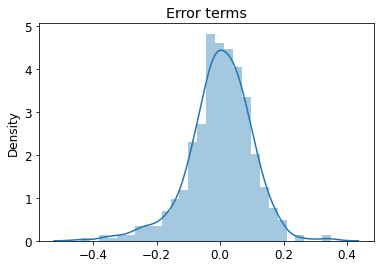

In [48]:
# distrubition plot for residue
res = y_train - y_train_pred
sns.distplot(res)
plt.title('Error terms')
plt.show()

**Insights:**
- The distribution plot of error term shows the normal distribution with mean at Zero.

Text(0, 0.5, 'Residual')

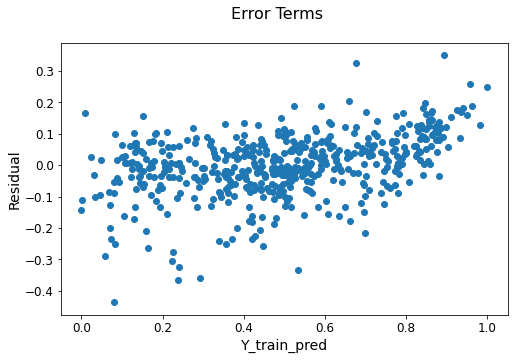

In [49]:
# Error terms train set
c = [i for i in range(1,len(y_train)+1,1)]
fig = plt.figure(figsize=(8,5))
plt.scatter(y_train,res)
fig.suptitle('Error Terms', fontsize=16)              # Plot heading 
plt.xlabel('Y_train_pred', fontsize=14)                      # X-label
plt.ylabel('Residual', fontsize=14)   

**Insights:**
- It seems like the corresponding residual plot is reasonably random. 
- Also the error terms satisfies to have reasonably constant variance (homoscedasticity) 

### 4.4 Prediction on test set

In [50]:
# check dataframe for the test set
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,...,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0.817910,0.265533,0.165370,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [51]:
# select final variables from X_test
X_test_sm = X_test[var_final]
X_test_sm.head()

,yr,holiday,temp,windspeed,season_summer,season_winter,mnth_sep,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0.652175,0.393568,0,0,0,0,1
374,1,0,0.276477,0.340487,0,0,0,0,0
181,0,0,0.817910,0.165370,0,0,0,0,0
529,1,0,0.720868,0.476922,1,0,0,0,0
233,0,0,0.777567,0.524373,0,0,0,0,0


In [52]:
# add constant
X_test_sm = sm.add_constant(X_test_sm)
X_test_sm.head()

,const,yr,holiday,temp,windspeed,season_summer,season_winter,mnth_sep,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1.0,1,0,0.652175,0.393568,0,0,0,0,1
374,1.0,1,0,0.276477,0.340487,0,0,0,0,0
181,1.0,0,0,0.817910,0.165370,0,0,0,0,0
529,1.0,1,0,0.720868,0.476922,1,0,0,0,0
233,1.0,0,0,0.777567,0.524373,0,0,0,0,0


In [53]:
# predict test dataset
y_test_pred = lm_final.predict(X_test_sm)

### 4.5 Evaluate the model on test set

In [54]:
# Get R-Squared fro test dataset
r2_test = r2_score(y_true = y_test, y_pred = y_test_pred)
print('R-Squared for Test dataset: ', round(r2_test,3))

R-Squared for Test dataset:  0.815


In [55]:
# Adj. R-Squared for test dataset
N= len(X_test)          # sample size
p =len(var_final)     # Number of independent variable
r2_test_adj = round((1-((1-r2_test)*(N-1)/(N-p-1))),3)
print('Adj. R-Squared for Test dataset: ', round(r2_test_adj,3))

Adj. R-Squared for Test dataset:  0.807


In [56]:
# Mean Sqare Error
mse = mean_squared_error(y_test, y_test_pred)
print('Mean_Squared_Error :' ,round(mse,4))

Mean_Squared_Error : 0.0096


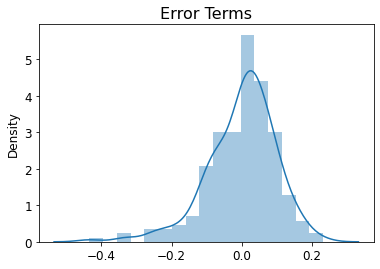

In [57]:
res_test = y_test - y_test_pred
plt.title('Error Terms', fontsize=16) 
sns.distplot(res_test)
plt.show()

- The distribution plot of error term shows the normal distribution with mean at Zero.

Text(0, 0.5, 'Residual')

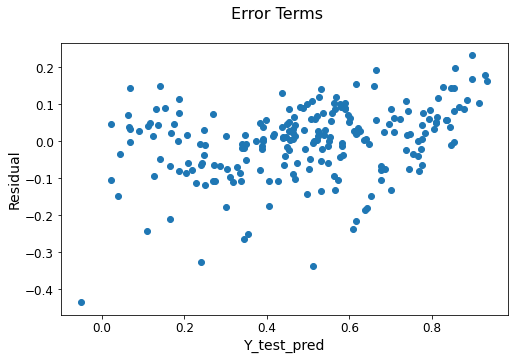

In [58]:
# Error terms
c = [i for i in range(1,len(y_test)+1,1)]
fig = plt.figure(figsize=(8,5))
plt.scatter(y_test,res_test)
fig.suptitle('Error Terms', fontsize=16)              # Plot heading 
plt.xlabel('Y_test_pred', fontsize=14)                      # X-label
plt.ylabel('Residual', fontsize=14)   

- It seems like the corresponding residual plot is reasonably random.

Text(0, 0.5, 'y_test_pred')

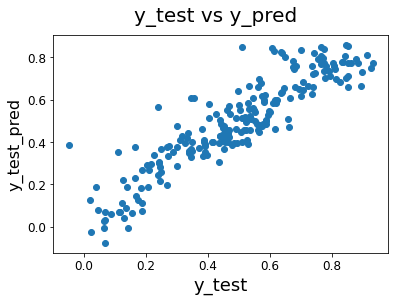

In [59]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_pred', fontsize = 16)      

**Insights:**
- We can colude that the model `lm_5` fit isn't by chance, and has descent predictive power.

### Step-5: Conclusions

In [60]:
# Print R Squared and adj. R Squared
print('R- Sqaured train: ', round(lm_final.rsquared,2), '  Adj. R-Squared train:', round(lm_final.rsquared_adj,3) )
print('R- Sqaured test : ', round(r2_test,2), '  Adj. R-Squared test :', round(r2_test_adj,3))

# Print the coefficents of final varible
print('\033[1m{:10s}\033[0m'.format('\nCoefficent for the variables are:'))
print(round(lm_final.params,3))

R- Sqaured train:  0.82   Adj. R-Squared train: 0.819
R- Sqaured test :  0.81   Adj. R-Squared test : 0.807

Coefficent for the variables are:
const                             0.097
yr                                0.256
holiday                          -0.097
temp                              0.552
windspeed                        -0.135
season_summer                     0.092
season_winter                     0.143
mnth_sep                          0.093
weathersit_Mist_Cloudy           -0.085
weathersit_LightSnow_LightRain   -0.264
dtype: float64


The equation of our best fitted line is:

$ cnt = 0.097 + (0.256  \times  yr) + (0.097  \times  holiday) + (0.552 \times temp) - (0.135 \times windspeed) + (0.092 \times SeasonSummer) + (0.143 \times SeasonWinter) + (0.093 \times MonthSep) - (0.085 \times WeathersitMistCloudy) - (0.264 \times weathersitLightSnowLightRain) $

- From R-Sqaured and adj R-Sqaured value of both train and test dataset we could conclude that the above variables can well explain more than 80% of bike demand.
- Coeffiencients of the variables explains the factors effecting the bike demand

- Based on final model top three features contributing significantly towards explaining the demand are:
    1. Temperature (0.552)
    2. weathersit : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds (-0.264)
    3. year (0.256)


- **So it recomended to give these variables utmost importance while planning to achieve maximum demand.**